# Melanoma Detection Assignment by Simranjit Kaur

---

**Business objective:** 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. 

It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Goals:**

- Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

**The data set contains the following diseases:**

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

---
**Importing Libraries**

In [1]:
# importing libraries for data visualization, model building and training

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation,MaxPooling2D
from glob import glob

**Supress Warnings**

In [2]:
import warnings
warnings.filterwarnings('ignore')

**Importing dataset to Google Drive**

In [3]:
# mounting the google drive
# please enter the authorization code when prompted for mapping gdrive

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# downloading the dataset zip file to google drive as /content/drive/My Drive/CNN_dataset.zip
# skipping virus scan for large file for automatic download

!wget -q --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs' -O- \
     | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
!wget -q --load-cookies cookies.txt -O "/content/drive/My Drive/CNN_dataset.zip" \
     'https://docs.google.com/uc?export=download&id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&confirm='$(<confirm.txt)

print("zip file downloaded successfully..")

zip file downloaded successfully..


In [5]:
# Unzipping the downloaded zip file to /content/drive/My Drive/CNN_dataset/

!unzip -qq "/content/drive/MyDrive/CNN_dataset.zip" -d "/content/drive/My Drive/CNN_dataset/"

print("unzip completed successfully..")

unzip completed successfully..


---

# Data Reading & Understanding
---

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# defining the path for train and test images

data_dir_train = pathlib.Path("/content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
# counting the total train and test images, dataset has total 2357 images

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


---

# Dataset creation
---

**Load using keras.preprocessing**

- Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [8]:
# defining parameters for the loader

batch_size = 32
img_height = 180
img_width = 180

- We will use 80% of the images for training, and 20% for validation.

In [9]:
# creating a training dataset with seed=123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
# creating a validation dataset with seed=123

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# listing out all the classes of skin cancer and storing them in a list. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


---

# Data Visualisation
---

- Visualizing one instance of all the nine classes present in the dataset

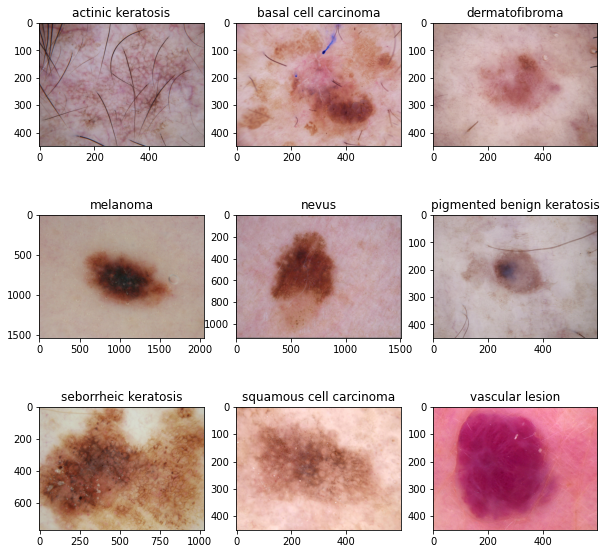

In [12]:
# Visualizing the image from training/validation dataset from each class

plt.figure(figsize=(10,10))

for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

---

# Model Building & Training
---

### Model 1 - without augmented data
---

**Creating a CNN model, which can accurately detect 9 classes present in the dataset.**

- Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). 


**Creating the model 1**

In [14]:
# creating a CNN model 1 with softmax activation function & drop out layers
# Model building - Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense


num_classes = 9

cnn_model1 = Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.20),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
    ])

**Compiling the model**

As it is a multi class classification, we are using the SparseCategoricalCrossEntropy as the loss function, and adam optimizer as a hit & trial.

In [15]:
# choosing an optimiser and loss function

cnn_model1.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [16]:
# getting the summary of all layers

cnn_model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

**Training the model**

In [17]:
# fitting the model for epochs value as '20'

epochs=20
history = cnn_model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 36s 115ms/step - loss: 1.9289 - accuracy: 0.2963 - val_loss: 1.9003 - val_accuracy: 0.2796
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6312 - accuracy: 0.4275 - val_loss: 1.6104 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4471 - accuracy: 0.5017 - val_loss: 1.4672 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 2s 44ms/step - loss: 1.3331 - accuracy: 0.5268 - val_loss: 1.3970 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2203 - accuracy: 0.5686 - val_loss: 1.3603 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.1036 - accuracy: 0.6116 - val_loss: 1.4047 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 2s 42ms/step - loss: 1.0901 - accuracy: 0.6122 - val_loss: 1.3724 - val_accuracy: 0.5593
Epoch 8/20


**Visualizing training results**

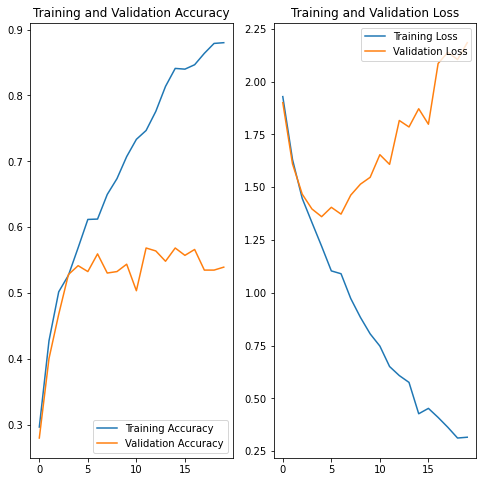

In [18]:
# plotting the accuracy for training & validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- Around the 15-20 epochs, we can detect a huge difference in loss functions between training and validation.
- We can see that the model is overfitting.
- It can be reduced by having a deeper model & adding a data augmentation layer before it.

---

## Data augmentation
---

### Model 2 - with augmented data
---

In [19]:
# performing data augumentation for model 2

data_augmentation = keras.Sequential( [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ])

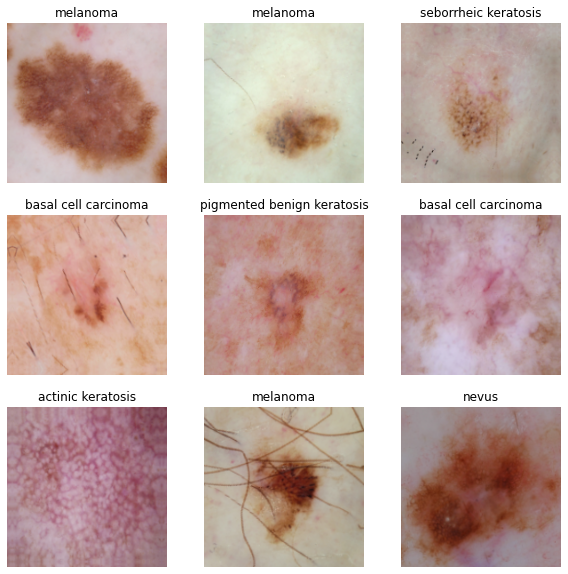

In [20]:
# Visualizing the augmentation strategy with one instance of training image

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Creating the model 2**


In [21]:
# creating a CNN model 2 with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense

num_classes = 9

cnn_model2 = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.20),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
    ])

**Compiling the model**

In [22]:
# choosing an optimiser and loss function

cnn_model2.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

**Training the model**

In [23]:
# fitting the model for epochs value as '20'

epochs=20
history = cnn_model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 54ms/step - loss: 1.8087 - accuracy: 0.3471 - val_loss: 1.5885 - val_accuracy: 0.4385
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 1.5347 - accuracy: 0.4420 - val_loss: 1.4634 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4230 - accuracy: 0.5073 - val_loss: 1.4631 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4206 - accuracy: 0.5095 - val_loss: 1.3948 - val_accuracy: 0.5324
Epoch 5/20
56/56 [==============================] - 3s 48ms/step - loss: 1.3221 - accuracy: 0.5301 - val_loss: 1.3948 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 3s 48ms/step - loss: 1.2938 - accuracy: 0.5329 - val_loss: 1.3229 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 3s 48ms/step - loss: 1.2301 - accuracy: 0.5536 - val_loss: 1.4012 - val_accuracy: 0.5078
Epoch 8/20
56

**Visualizing the results**

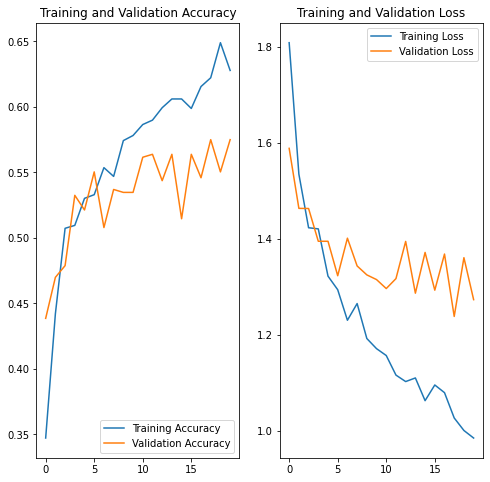

In [24]:
# plotting the accuracy for training & validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- We can see that the model is not overfitting after implementing data augmentation.
- There is no much improvement with respect to accuracy from the base model.

---
# Class distribution
---

### Finding the distribution of classes in the training dataset.
---

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. 

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## creating a list with class name and no of samples

class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [26]:
## creating a dataframe with class name and no of samples

df_class = pd.DataFrame(class_size.items(), columns = ['Class Name', 'Number of Samples'])

df_class

,Class Name,Number of Samples
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


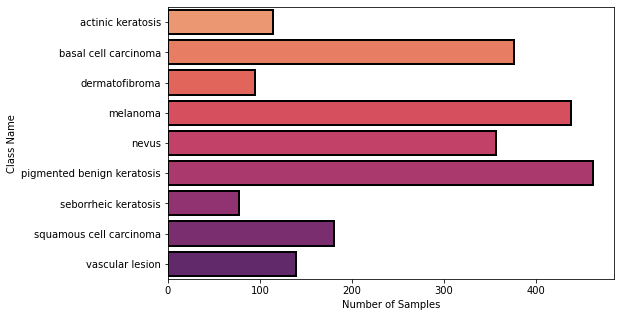

In [27]:
# plotting dataframe for showing class imbalance

plt.figure(figsize=[8,5])
sns.barplot(x='Number of Samples',y='Class Name', data=df_class,saturation=1,edgecolor=(0,0,0),linewidth=2,palette='flare')
plt.show()

#### Observations:

- 'seborrheic keratosis' class has a least number of samples.
- 'pigmented benign keratosis' class dominates the data in terms proportionate number of samples.

---
# Handling class imbalances
---

### Rectifing the class imbalance
---

We are using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
# executing Augmentor to generate 500 samples per class

path_to_training_dataset='/content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F445DA45C10>: 100%|██████████| 500/500 [00:22<00:00, 22.17 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F445D956290>: 100%|██████████| 500/500 [00:22<00:00, 22.68 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F44D709E410>: 100%|██████████| 500/500 [00:22<00:00, 22.24 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F445D9563D0>: 100%|██████████| 500/500 [01:48<00:00,  4.61 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F445C7FDC90>: 100%|██████████| 500/500 [01:33<00:00,  5.36 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F44D714D150>: 100%|██████████| 500/500 [00:22<00:00, 21.90 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F44D709E410>: 100%|██████████| 500/500 [00:47<00:00, 10.43 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F445DADEE10>: 100%|██████████| 500/500 [00:27<00:00, 18.41 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F44D0140690>: 100%|██████████| 500/500 [00:23<00:00, 21.73 Samples/s]


In [30]:
# getting the count of new samples i.e. 500 * 9 = 4500

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [31]:
# creating a dataframe with class and no. of samples added

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [32]:
# getting the count of new samples in each class

df2['Label'].value_counts()

actinic keratosis             500
pigmented benign keratosis    500
basal cell carcinoma          500
melanoma                      500
seborrheic keratosis          500
vascular lesion               500
nevus                         500
dermatofibroma                500
squamous cell carcinoma       500
Name: Label, dtype: int64

Now we have added 500 images to all the classes to maintain some class balance. 

### Model 3 - on the rectified class imbalance data with data augmentation
---

We are also including data augmentation for handling underfitting/overfitting with class imbalance.

In [33]:
# defining parameters for the loader

batch_size = 32
img_height = 180
img_width = 180

In [34]:
# creating a training dataset with seed=123

data_dir_train='/content/drive/My Drive/CNN_dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [35]:
# creating a validation dataset with seed=123

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
# performing data augumentation for model 3

data_augmentation = keras.Sequential( [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ])

**Creating the model 3**

In [38]:
# creating a CNN model 3 with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense

num_classes = 9
cnn_model3 = Sequential ([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.20),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
    ])

**Compiling the model**

In [39]:
# choosing an optimiser and loss function

cnn_model3.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [40]:
# Getting the summary of all layers

cnn_model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

**Training the model**

In [41]:
# fitting the model for epochs value as '50'

epochs = 50
history = cnn_model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 46s 95ms/step - loss: 2.0908 - accuracy: 0.2185 - val_loss: 1.6655 - val_accuracy: 0.3638
Epoch 2/50
169/169 [==============================] - 8s 49ms/step - loss: 1.6015 - accuracy: 0.3863 - val_loss: 1.4340 - val_accuracy: 0.4573
Epoch 3/50
169/169 [==============================] - 8s 49ms/step - loss: 1.5074 - accuracy: 0.4139 - val_loss: 1.3815 - val_accuracy: 0.4647
Epoch 4/50
169/169 [==============================] - 8s 49ms/step - loss: 1.3976 - accuracy: 0.4588 - val_loss: 1.4500 - val_accuracy: 0.4439
Epoch 5/50
169/169 [==============================] - 8s 49ms/step - loss: 1.3402 - accuracy: 0.4922 - val_loss: 1.2082 - val_accuracy: 0.5405
Epoch 6/50
169/169 [==============================] - 8s 49ms/step - loss: 1.2783 - accuracy: 0.5089 - val_loss: 1.1844 - val_accuracy: 0.5486
Epoch 7/50
169/169 [==============================] - 8s 49ms/step - loss: 1.2903 - accuracy: 0.5022 - val_loss: 1.2134 - val_accuracy: 0.549

**Visualizing the model results**

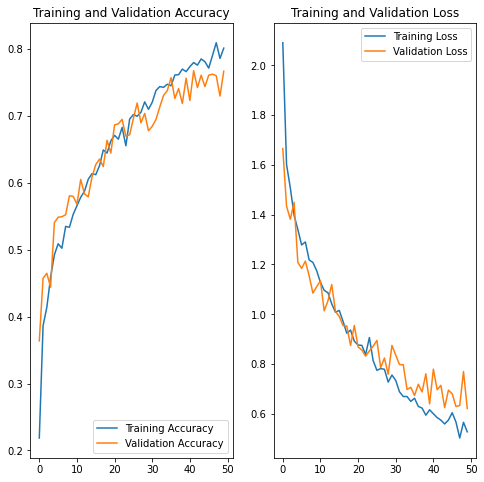

In [42]:
# plotting the accuracy for training & validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- Model looks fine now with an accurracy of approx. 80%. It can be improved further by having a deeper model & hyperparameter optimization with a change in the optimizer.
- Class rebalancing helped us in getting better accuracy.
- We can see that the model is not overfitting now.